# Exercise: EDA

This exercise is a continuation of the exploratory data analysis of the Citibike Trip Histories dataset. The first section shows code to prepare the data, followed by a section of the initial analysis. Your task is complete the EDA of the Citibike dataset. The instructions are stated in the last section of this notebook.

**IMPORTANT:** Copy this notebook and make changes in that copy. Do not push changes to this notebook.

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data - CitiBike Trip Histories

CitiBike provides the data of the bike share through this website: https://www.citibikenyc.com/system-data

For this exercise, we'll be using their trip history data which may be found [here](https://s3.amazonaws.com/tripdata/index.html). 

In [2]:
#os.environ['DSDATA'] = r'C:\Users\Niko\Desktop\git\DATA'
#data = os.getenv('DSDATA')
#data

In [3]:
#data = pd.read_csv(os.getenv('DSDATA') + '/202102-citibike-tripdata.csv')
data = pd.read_csv('202102-citibike-tripdata.csv')
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,683,2021-02-01 00:08:57.2940,2021-02-01 00:20:21.2680,3483,Montgomery St,40.719420,-74.050990,3203,Hamilton Park,40.727596,-74.044247,40517,Subscriber,1958,1
1,2850,2021-02-01 00:21:12.4910,2021-02-01 01:08:42.9560,3203,Hamilton Park,40.727596,-74.044247,3275,Columbus Drive,40.718355,-74.038914,40517,Subscriber,1958,1
2,545,2021-02-01 00:53:08.7500,2021-02-01 01:02:14.3890,3220,5 Corners Library,40.734961,-74.059503,3212,Christ Hospital,40.734786,-74.050444,44907,Customer,1996,1
3,473,2021-02-01 00:59:10.1110,2021-02-01 01:07:03.8480,3220,5 Corners Library,40.734961,-74.059503,3210,Pershing Field,40.742677,-74.051789,29727,Subscriber,1987,2
4,748,2021-02-01 01:01:29.4990,2021-02-01 01:13:57.8940,3210,Pershing Field,40.742677,-74.051789,3269,Brunswick & 6th,40.726012,-74.050389,45550,Subscriber,1962,1


## Feature Extraction

In [4]:
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

data['dayofweek'] = data['starttime'].dt.dayofweek
data['hourofday'] = data['starttime'].dt.hour
data['year'] = data['starttime'].dt.year

## Feature Transformation

In [5]:
data['duration_min'] = data['tripduration']/60

## Feature Generation

In [6]:
data['age'] = data['starttime'].dt.year - data['birth year']
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dayofweek,hourofday,year,duration_min,age
0,683,2021-02-01 00:08:57.294,2021-02-01 00:20:21.268,3483,Montgomery St,40.719420,-74.050990,3203,Hamilton Park,40.727596,-74.044247,40517,Subscriber,1958,1,0,0,2021,11.383333,63
1,2850,2021-02-01 00:21:12.491,2021-02-01 01:08:42.956,3203,Hamilton Park,40.727596,-74.044247,3275,Columbus Drive,40.718355,-74.038914,40517,Subscriber,1958,1,0,0,2021,47.500000,63
2,545,2021-02-01 00:53:08.750,2021-02-01 01:02:14.389,3220,5 Corners Library,40.734961,-74.059503,3212,Christ Hospital,40.734786,-74.050444,44907,Customer,1996,1,0,0,2021,9.083333,25
3,473,2021-02-01 00:59:10.111,2021-02-01 01:07:03.848,3220,5 Corners Library,40.734961,-74.059503,3210,Pershing Field,40.742677,-74.051789,29727,Subscriber,1987,2,0,0,2021,7.883333,34
4,748,2021-02-01 01:01:29.499,2021-02-01 01:13:57.894,3210,Pershing Field,40.742677,-74.051789,3269,Brunswick & 6th,40.726012,-74.050389,45550,Subscriber,1962,1,0,1,2021,12.466667,59


#### Distance

Another feature we can generate from the data is distance. Although the provided values are in longitude and latitudes and they're measured in degrees, the distance calculated from these points would also be in degrees (and not meters). 

There's actually a library that specifically handles geospatial data called `geopy` ([Link](https://geopy.readthedocs.io/en/stable/#module-geopy.distance)). For simplicity sake in this tutorial, we use an existing function that calculates the geodesic distance using the Haversine formula given the starting and ending longitude and latitudes: `calculate_distance(lat1, lon1, lat2, lon2)`

Credits to [Wayne Dyck](https://gist.github.com/rochacbruno/2883505) for the function.

In [7]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the distance provided a pair of longitudes and latitudes
    using the Haversine formula
    
    Returns the distance in kilometers.
    """
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [8]:
data['distance_km'] = data.apply(lambda x: calculate_distance(x['start station latitude'], x['start station longitude'],
                                        x['end station latitude'], x['end station longitude']), axis=1)

# Exploratory Data Analysis

We will do the following:
1. Examine the size and structure of the data
2. Examine each field individually
3. Examine relationships/correlations
4. Identify anomalies/outliers

## 1. Size and structure of the data

In [9]:
data.shape

(4725, 21)

After feater transformations, the dataset now has 634,631 observations with 21 variables.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4725 entries, 0 to 4724
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   tripduration             4725 non-null   int64         
 1   starttime                4725 non-null   datetime64[ns]
 2   stoptime                 4725 non-null   datetime64[ns]
 3   start station id         4725 non-null   int64         
 4   start station name       4725 non-null   object        
 5   start station latitude   4725 non-null   float64       
 6   start station longitude  4725 non-null   float64       
 7   end station id           4725 non-null   int64         
 8   end station name         4725 non-null   object        
 9   end station latitude     4725 non-null   float64       
 10  end station longitude    4725 non-null   float64       
 11  bikeid                   4725 non-null   int64         
 12  usertype                 4725 non-

The dataset has a variety of datatypes: integer and float values, date and time, and strings. There are no variables with null/missing values.

In [11]:
# Get descriptive statistics of quantitative variables
data.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,dayofweek,hourofday,year,duration_min,age,distance_km
count,4.725000e+03,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.000000,4725.0,4725.000000,4725.000000,4725.000000
mean,1.670438e+03,3304.241481,40.722727,-74.047113,3302.378624,40.722550,-74.046446,41115.517037,1972.799365,0.289735,3.268995,15.208889,2021.0,27.840631,48.200635,1.028391
std,2.041336e+04,181.453889,0.006908,0.011888,197.710038,0.006754,0.011639,5683.095080,7.463825,0.547945,1.889804,7.223199,0.0,340.222716,7.463825,0.731979
min,6.100000e+01,3184.000000,40.711130,-74.083639,151.000000,40.703554,-74.083639,24987.000000,1949.000000,0.000000,0.000000,0.000000,2021.0,1.016667,20.000000,0.000000
25%,3.250000e+02,3195.000000,40.717733,-74.051789,3195.000000,40.717733,-74.050656,39661.000000,1970.000000,0.000000,2.000000,12.000000,2021.0,5.416667,51.000000,0.570314
50%,5.290000e+02,3210.000000,40.721630,-74.044247,3209.000000,40.721525,-74.043845,42495.000000,1970.000000,0.000000,3.000000,18.000000,2021.0,8.816667,51.000000,0.889020
75%,9.500000e+02,3276.000000,40.727551,-74.038051,3276.000000,40.727224,-74.037683,44744.000000,1970.000000,0.000000,5.000000,21.000000,2021.0,15.833333,51.000000,1.430533
max,1.086982e+06,3792.000000,40.748716,-74.032108,3794.000000,40.751873,-73.977706,49503.000000,2001.000000,2.000000,6.000000,23.000000,2021.0,18116.366667,72.000000,8.349835


Although these variables are all quantitative, it doesn't really make sense to look at the statistics for unique IDs and spatial data like `start station id`, `start station latitude`, `start station longitude`, and `bikeid`, among others. Here, we will just focus on the values for `birth year`, `duration_min`, `age`, and `distance_km`.

Few insights from the `data.describe()` function:

1. The minimum `birth year` is 1885 which has a remarkably large difference from the 25th percentile value. Can this be anomalous data?
2. There is a very large difference between the maximum and 75th percentile values of `duration_min` and `age`.
3. Observations #1 & #2 indicate possible outliers in the data. 

In [12]:
data.describe(include=np.object)

,start station name,end station name,usertype
count,4725,4725,4725
unique,51,55,2
top,Newport Pkwy,Grove St PATH,Customer
freq,287,298,3624


These are the descriptive stats for the categorical variables. 

## 2. Examining individual variables

Now, we can start generating simple visualizations to help us better understand the values in each variable.

#### User type

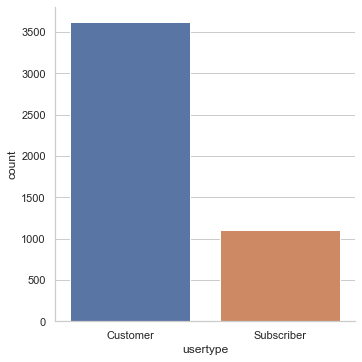

In [13]:
sns.set_theme(style="whitegrid")

usertype_plot = sns.catplot(x="usertype", kind="count", order=["Customer", "Subscriber"], data=data)

There are more one-time users of CitiBike than there are subscribers.

#### Age

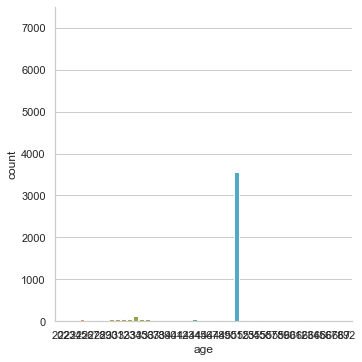

In [14]:
age_plot = sns.catplot(x="age", kind="count", data=data)
age_plot.set(ylim=(0,7500)) # Limit the maximum y-axis value because of one outlier count for age 52

In [15]:
data["age"].value_counts()

51    3563
34     120
31      65
30      65
33      55
32      52
44      50
36      49
35      47
25      43
42      40
41      38
48      36
29      32
61      30
38      29
37      29
39      28
63      28
28      25
23      23
52      22
53      20
55      20
27      19
62      19
40      18
46      17
26      13
43      13
59      12
50      11
65      10
54      10
49       9
57       9
72       8
45       8
24       6
64       5
56       5
60       4
69       4
68       4
47       3
58       3
67       2
22       2
66       1
20       1
Name: age, dtype: int64

#### Starting Stations

In [16]:
start_stations = data["start station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
start_stations = start_stations.nlargest(10, 'counts')
start_stations

,Station name,counts
0,Newport Pkwy,287
1,Grove St PATH,272
2,Hamilton Park,269
3,Marin Light Rail,225
4,Sip Ave,217
5,Newport PATH,201
6,Warren St,163
7,Harborside,161
8,JC Medical Center,157
9,Columbus Dr at Exchange Pl,154


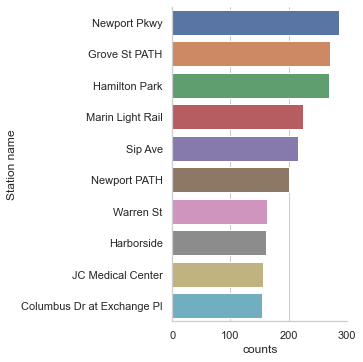

In [17]:
start_station_plot = sns.catplot(y="Station name", x="counts", orient="h", kind="bar", data=start_stations)

#### Ending stations

In [18]:
end_stations = data["end station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
end_stations = end_stations.nlargest(10, 'counts')
end_stations

,Station name,counts
0,Grove St PATH,298
1,Newport Pkwy,293
2,Hamilton Park,261
3,Sip Ave,220
4,Newport PATH,218
5,Marin Light Rail,208
6,Warren St,164
7,City Hall,164
8,JC Medical Center,163
9,Harborside,161


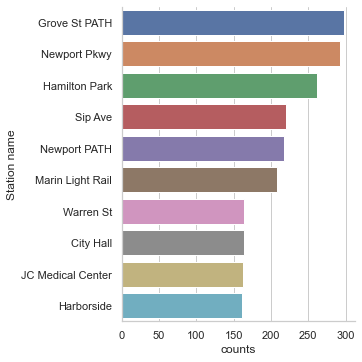

In [19]:
end_station_plot = sns.catplot(y="Station name", x="counts", orient="h", kind="bar", data=end_stations)

We can see from both plots that the top 10 start and end stations are consistent with each other. This indicates high taffic areas which can be potential locations for adding more bikes and bike docks. 

#### Origin-Destination Pairs

Here we create `od_trips` which contains the origin-destination pairs derived from the unique pairs of `start station name` and `end station name`.

In [20]:
## Count of rides per OD
od_trips = data.groupby(['start station name', 'end station name'], as_index=False)['bikeid'].count()
od_trips = od_trips.rename(columns={"start station name": "start", "end station name": "end", "bikeid": "total_trips"}, errors="raise")
od_trips

,start,end,total_trips
0,5 Corners Library,5 Corners Library,3
1,5 Corners Library,Brunswick St,1
2,5 Corners Library,Christ Hospital,3
3,5 Corners Library,City Hall,1
4,5 Corners Library,Columbus Drive,1
...,...,...,...
1149,York St,Newport Pkwy,1
1150,York St,Paulus Hook,1
1151,York St,Van Vorst Park,1
1152,York St,Warren St,1


In [21]:
od_trips["od"] = od_trips["start"] + " to " + od_trips["end"]
od_trips

,start,end,total_trips,od
0,5 Corners Library,5 Corners Library,3,5 Corners Library to 5 Corners Library
1,5 Corners Library,Brunswick St,1,5 Corners Library to Brunswick St
2,5 Corners Library,Christ Hospital,3,5 Corners Library to Christ Hospital
3,5 Corners Library,City Hall,1,5 Corners Library to City Hall
4,5 Corners Library,Columbus Drive,1,5 Corners Library to Columbus Drive
...,...,...,...,...
1149,York St,Newport Pkwy,1,York St to Newport Pkwy
1150,York St,Paulus Hook,1,York St to Paulus Hook
1151,York St,Van Vorst Park,1,York St to Van Vorst Park
1152,York St,Warren St,1,York St to Warren St


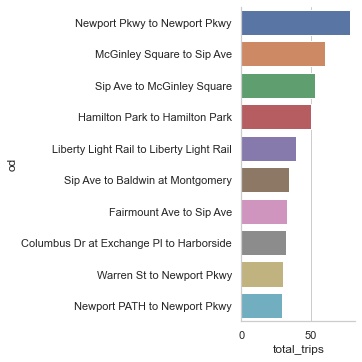

In [22]:
od_rank_plot = sns.catplot(y="od", x="total_trips", orient="h", kind="bar", data=od_trips.nlargest(10, "total_trips"))

#### Origin-Destination Matrix

In this part, we focus on analyzing the number of trips between the top 10 `start` and `end` stations. It would be impossible to visually analyze for all possible pairs because the dataset is too big.

In [23]:
# Get the trips between the top 10 stations.

od_topten = od_trips[od_trips.start.isin(start_stations["Station name"]) & od_trips.end.isin(end_stations["Station name"])]
od_topten

,start,end,total_trips,od
179,Columbus Dr at Exchange Pl,City Hall,2,Columbus Dr at Exchange Pl to City Hall
185,Columbus Dr at Exchange Pl,Grove St PATH,4,Columbus Dr at Exchange Pl to Grove St PATH
186,Columbus Dr at Exchange Pl,Hamilton Park,5,Columbus Dr at Exchange Pl to Hamilton Park
187,Columbus Dr at Exchange Pl,Harborside,32,Columbus Dr at Exchange Pl to Harborside
192,Columbus Dr at Exchange Pl,Marin Light Rail,9,Columbus Dr at Exchange Pl to Marin Light Rail
...,...,...,...,...
1087,Warren St,JC Medical Center,8,Warren St to JC Medical Center
1092,Warren St,Marin Light Rail,8,Warren St to Marin Light Rail
1098,Warren St,Newport PATH,12,Warren St to Newport PATH
1099,Warren St,Newport Pkwy,30,Warren St to Newport Pkwy


In [24]:
# Create a matrix

od_matrix = pd.pivot_table(od_topten, index='start', columns='end', values='total_trips', aggfunc=np.sum, fill_value=0)
od_matrix

end,City Hall,Grove St PATH,Hamilton Park,Harborside,JC Medical Center,Marin Light Rail,Newport PATH,Newport Pkwy,Sip Ave,Warren St
start,,,,,,,,,,
Columbus Dr at Exchange Pl,2,4,5,32,0,9,13,14,1,5
Grove St PATH,9,14,15,5,10,24,3,3,2,5
Hamilton Park,6,26,50,3,6,4,18,9,0,10
Harborside,1,8,4,21,2,3,22,11,1,2
JC Medical Center,13,10,9,1,24,15,12,3,0,9
Marin Light Rail,14,27,5,9,11,25,18,3,0,15
Newport PATH,5,3,18,22,6,12,12,29,1,7
Newport Pkwy,4,4,8,11,5,6,12,78,0,25
Sip Ave,1,0,0,1,0,0,3,2,16,1


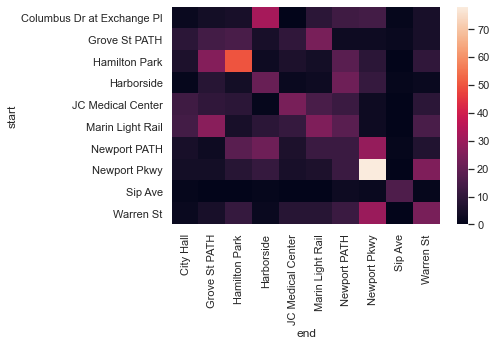

In [25]:
# Generate a heatmap

od_heatmap = sns.heatmap(od_matrix)

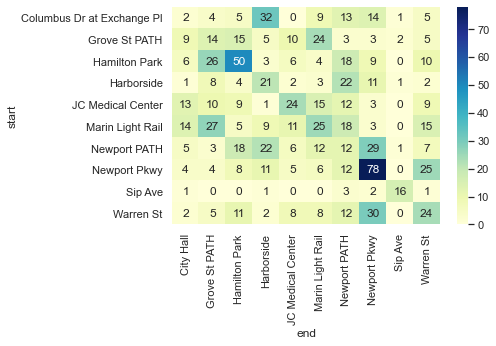

In [26]:
# Change color palette

od_heatmap = sns.heatmap(od_matrix, cmap="YlGnBu", annot=True, fmt="d")

#### Gender

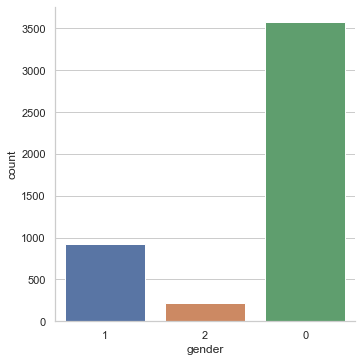

In [27]:
gender_plot = sns.catplot(x="gender", kind="count", order=[1, 2, 0], data=data)

It seems that the dataset contains mostly zero (0) values for the gender. We can continue our analysis by removing those trips with unknown gender.

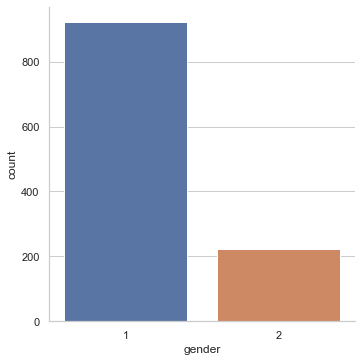

In [28]:
gender_plot = sns.catplot(x="gender", kind="count", order=[1, 2], data=data[data["gender"] > 0])

#### Day of week

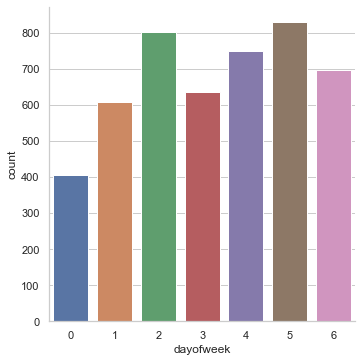

In [29]:
dow_plot = sns.catplot(x="dayofweek", kind="count", data=data)

The values for `dayofweek` starts with `0` or `Monday` and ends with `6` or `Sunday`. Based on the bar plot above, most trips happen on Wednesdays, Fridays and Saturdays.

#### Hour of day

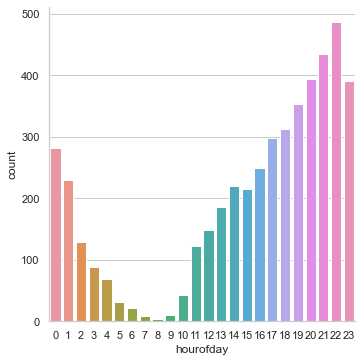

In [30]:
hod_plot = sns.catplot(x="hourofday", kind="count", data=data)

From the plot, the number of trips starts increasing from 12 noon and peaks at 5PM. 

#### Duration in minutes

In [31]:
data["duration_min"].describe()

count     4725.000000
mean        27.840631
std        340.222716
min          1.016667
25%          5.416667
50%          8.816667
75%         15.833333
max      18116.366667
Name: duration_min, dtype: float64

#### Detect and remove outliers

Outliers are defined as values that is more than 3 standard deviations away from the mean. Here, we detect them by computing the z score of each value, which is relative to the mean and standard deviation.

In [32]:
z_scores = zscore(data["duration_min"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_entries = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
duration_min_outliers = (abs_z_scores >= 3)
data[duration_min_outliers].duration_min # Show outlier values

20      18116.366667
392      4165.066667
647      5839.800000
1279     2380.333333
1567     1065.983333
1820     2310.266667
2481     2247.066667
2841     2233.266667
2943     1078.350000
3092     8577.983333
3821     5498.733333
3924     2154.800000
3969     5904.233333
Name: duration_min, dtype: float64

#### Histograms with KDE

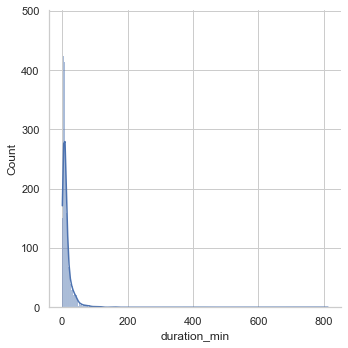

In [33]:
duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)

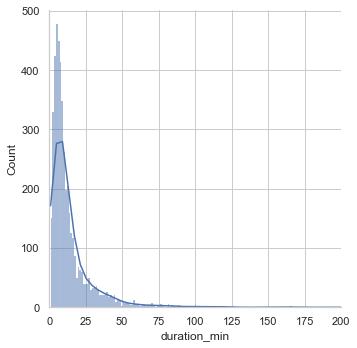

In [34]:
# Zoom in a little closer. Let's limit the x-axis to only show values up to 200

duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)
duration_plot.set(xlim=(0, 200))

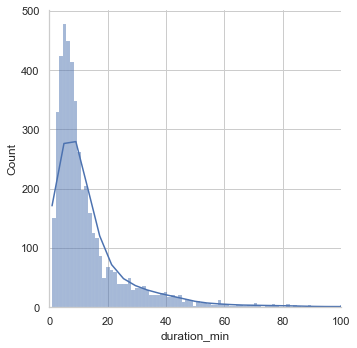

In [35]:
# Zoom in more. Let's limit the x-axis to only show values up to 100

duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)
duration_plot.set(xlim=(0, 100))

#### ECDF with Rug Plots

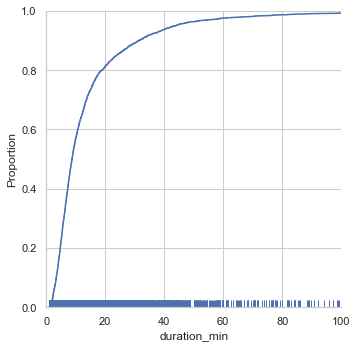

In [36]:
duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kind="ecdf", rug=True)
duration_plot.set(xlim=(0, 100))

## 3. Examine relationships/correlations

### User type and gender

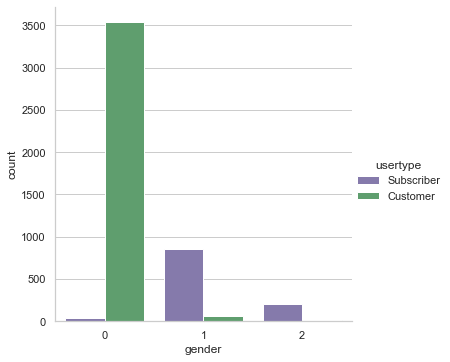

In [37]:
usertype_gender_plot = sns.catplot(x="gender", 
                                   kind="count", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   data=data)

- Users with 24-hour pass or 3-day passes did not have their gender information recorded.
- More male subscribers than females. 

### Trip distance, duration and user type

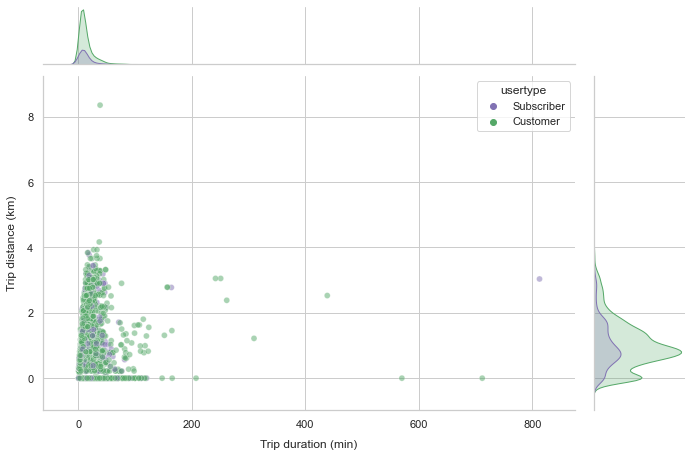

In [38]:
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

In [39]:
z_scores = zscore(data["distance_km"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_dist = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
dist_outliers = (abs_z_scores >= 3)
data[dist_outliers].distance_km # Show outlier values

87      3.281467
142     8.349835
196     3.281888
507     3.387563
1004    3.769794
1363    3.285017
1454    3.285017
1605    3.435339
1618    3.285143
1631    3.660745
1642    3.660745
1783    3.660745
1808    3.660745
2112    3.285017
2305    3.743791
2339    3.285017
2562    3.246917
2860    3.285017
2979    3.285017
3257    3.836830
3289    3.464111
3418    3.317784
3420    3.317784
3649    3.354213
3653    3.418478
3680    3.928430
3932    3.836830
3966    3.463201
4008    3.928430
4095    3.443084
4204    3.318394
4431    4.165345
Name: distance_km, dtype: float64

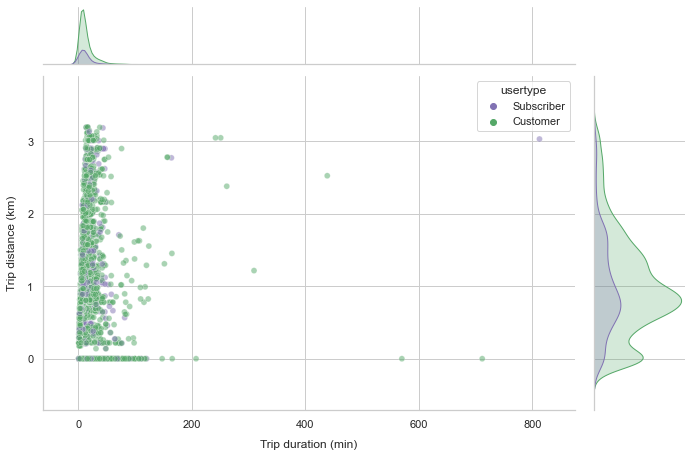

In [40]:
# Plot with outliers for both duration and distance
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries & filtered_dist], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

### Get correlation between quantitative variables

In [41]:
data_to_corr = data[["gender", "duration_min", "age", "distance_km"]]
data_to_corr

,gender,duration_min,age,distance_km
0,1,11.383333,63,1.072089
1,1,47.500000,63,1.121508
2,1,9.083333,25,0.763566
3,2,7.883333,34,1.076380
4,1,12.466667,59,1.856858
...,...,...,...,...
4720,1,5.916667,34,0.692491
4721,0,4.483333,51,0.692491
4722,0,3.216667,51,0.692491
4723,1,42.500000,63,1.307529


In [42]:
# Get z scores of the following variables
z_scores = zscore(data_to_corr[["duration_min", "age", "distance_km"]]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_rows = (abs_z_scores < 3).all(axis=1) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
data_to_corr_outliers = (abs_z_scores >= 3)
data_to_corr[data_to_corr_outliers] # Show outlier values

,gender,duration_min,age,distance_km
2,1,9.083333,25,0.763566
20,2,18116.366667,35,0.941277
31,1,14.366667,25,1.030527
53,1,13.033333,25,1.166187
64,1,16.100000,25,1.379661
...,...,...,...,...
4588,1,7.183333,25,1.114957
4608,2,10.766667,72,1.762006
4650,1,7.666667,25,1.030848
4682,1,9.350000,25,1.030848


In [43]:
# Remove outliers
data_to_corr = data_to_corr[filtered_rows]

#### Correlation Heatmap

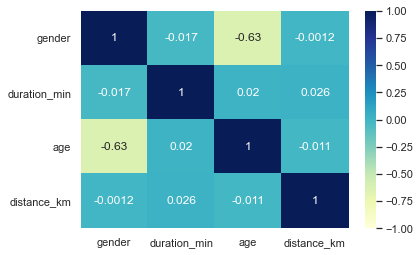

In [44]:
data_corr_heatmap = sns.heatmap(data_to_corr.corr(), 
                                center=0, 
                                cmap="YlGnBu", 
                                annot=True, 
                                vmin=-1, 
                                vmax=1)

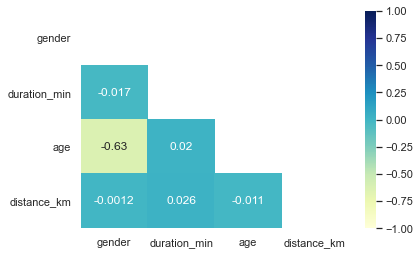

In [45]:
mask = np.triu(np.ones_like(data_to_corr.corr(), dtype=bool))

data_corr_heatmap = sns.heatmap(data_to_corr.corr(), 
                                center=0, 
                                cmap="YlGnBu", 
                                annot=True, 
                                mask=mask,
                                vmin=-1, 
                                vmax=1)

Variables `distance_km` and `duration_min` showed some positive correlation. We can still include them as features in a modeling task later.

----
----

# Exercise Proper: Continuation of EDA

We are already done in examining the individual characteristics of each variable in the dataset. You're task is to continue examining the remaining relationships (bivariate/multivariate) between variables. Here are some that you can prioritize:

- Bivariate: Trip duration & time of day
- Bivariate: User type & age
- Bivariate: Start station & user type
- Bivariate: End station & user type
- Bivariate: End station & gender
- Multi: Start station, end station & trip duration
- Multi: Start station, end station & unique users
- Multi: Start station, end station & user type
- Multi: Trip distance, duration & gender
- Multi: Average trip distance per unique user, average duration per unique user & user type
- Multi: Average trip distance per unique user, average duration per unique user, gender & user type

After creating simple visualizations for each, write down your observations in a separate cell. You do not have to interpret yet why those relationships appear. We're still doing EDA. Relax ;)

### Bivariate: Trip duration & time of day

<AxesSubplot:xlabel='hourofday', ylabel='duration_min'>

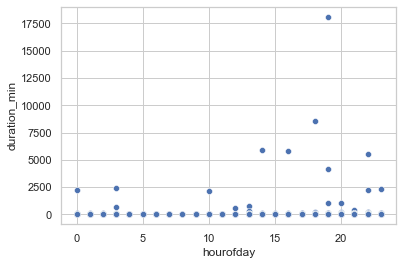

In [46]:
sns.scatterplot(x="hourofday",y="duration_min", data=data)

Here we can see that the durations are more frequent in the 0-5,000 minute range. We can generealize the data by grouping them into 6 hour intervals.

### Feature transformation

Time of day to Morning, Afternoone, Evening, Night

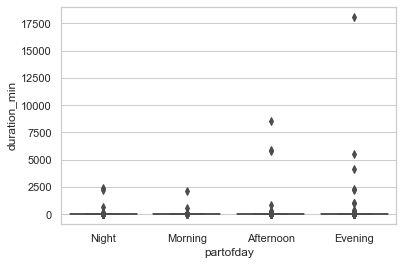

In [47]:
data=data.assign(partofday=pd.cut(data.hourofday,
                            [0,6,12,18,23],
                            labels=['Night','Morning','Afternoon','Evening'],
                            include_lowest=True))

td_tod_plot = sns.boxplot(x="partofday",y="duration_min", data=data)

Looking at the boxplot, there are many outliters. We can limit the range to get a better view of the data.

(0.0, 38.0)

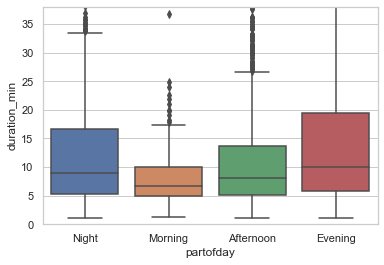

In [48]:
td_tod_plot = sns.boxplot(x="partofday",y="duration_min", data=data)
plt.ylim(0,38)

Based from the box plot we can see that most user spend a longer time using bikes in the `Afternoon (12:00-6:00pm)`, while they spend a shorter time at `Night(12:00am-6:00am)`.

### Bivariate: User type & age

In [49]:
a = data["age"].unique()
a.sort()
a

array([20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72],
      dtype=int64)

We can see that the ages of the users range between 17-136 years old.

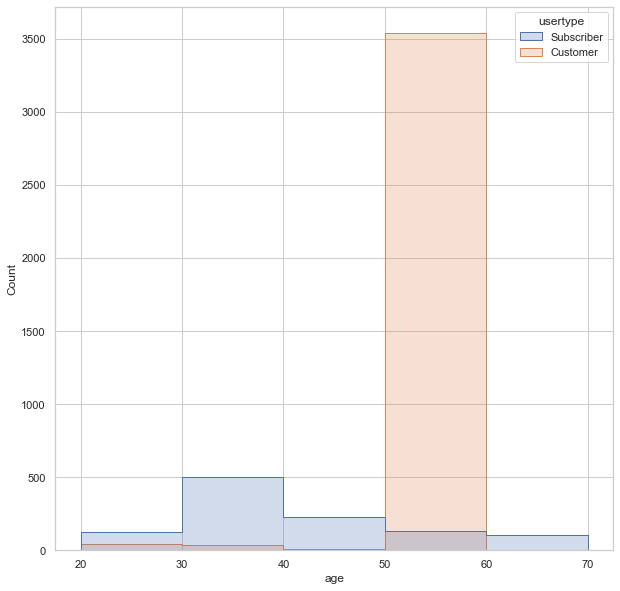

In [50]:
plt.figure(figsize=(10,10))
usertype_age_plot = sns.histplot(data=data, x="age", hue="usertype",element="step", binwidth=10, binrange=(20,65))
plt.locator_params(axis="y", nbins=10)

Based on the histogram, we can see that for each age group for subscribers, there is around `25,000-50,000 users`, with the most subscribers being under the age range of `30-40 years old`. For the customers, there is only around `1,000 users` for `20-50 years  old`, while the age group of `50-60 years old` reached  a user count of around `45,000+`

### Bivariate: Start Station and User Type

Placing variables to sort the stations from start and end.

In [51]:
sort_data_start = data
sort_data_start.sort_values(by=['start station name'], inplace=True)
sort_data_end = data
sort_data_end.sort_values(by=['end station name'], inplace=True)

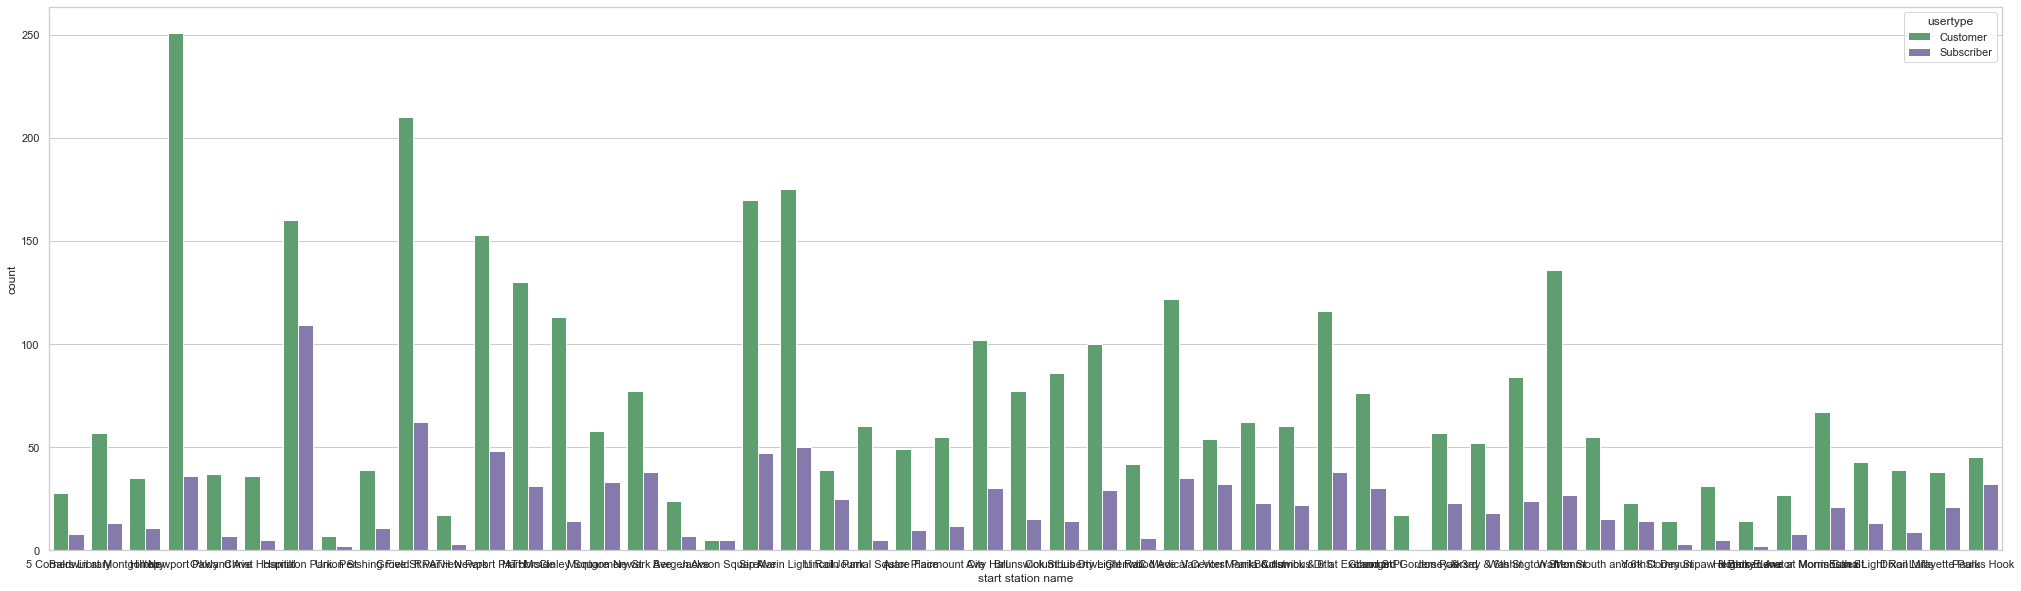

In [52]:
# Plotting
dimensions = (35, 10)
fig, ax = plt.subplots(figsize = dimensions)
usertype_station_plot = sns.countplot(x="start station name",  
                                      hue="usertype", 
                                      palette={"Customer": "g", "Subscriber": "m"}, 
                                      data=sort_data_start, ax=ax)

Stations in **Grove St. Path**, **Manila & 1st** and **Newport Path** have the highest number of customers. Otherwise, stations in **Heights Elevator**, **Jackson Square** and **Pershing Field** have the least number of customers and subscribers. **Hamilton Park** is a station where you can find the most number of subscribers.

### Bivariate: End Station and Gender

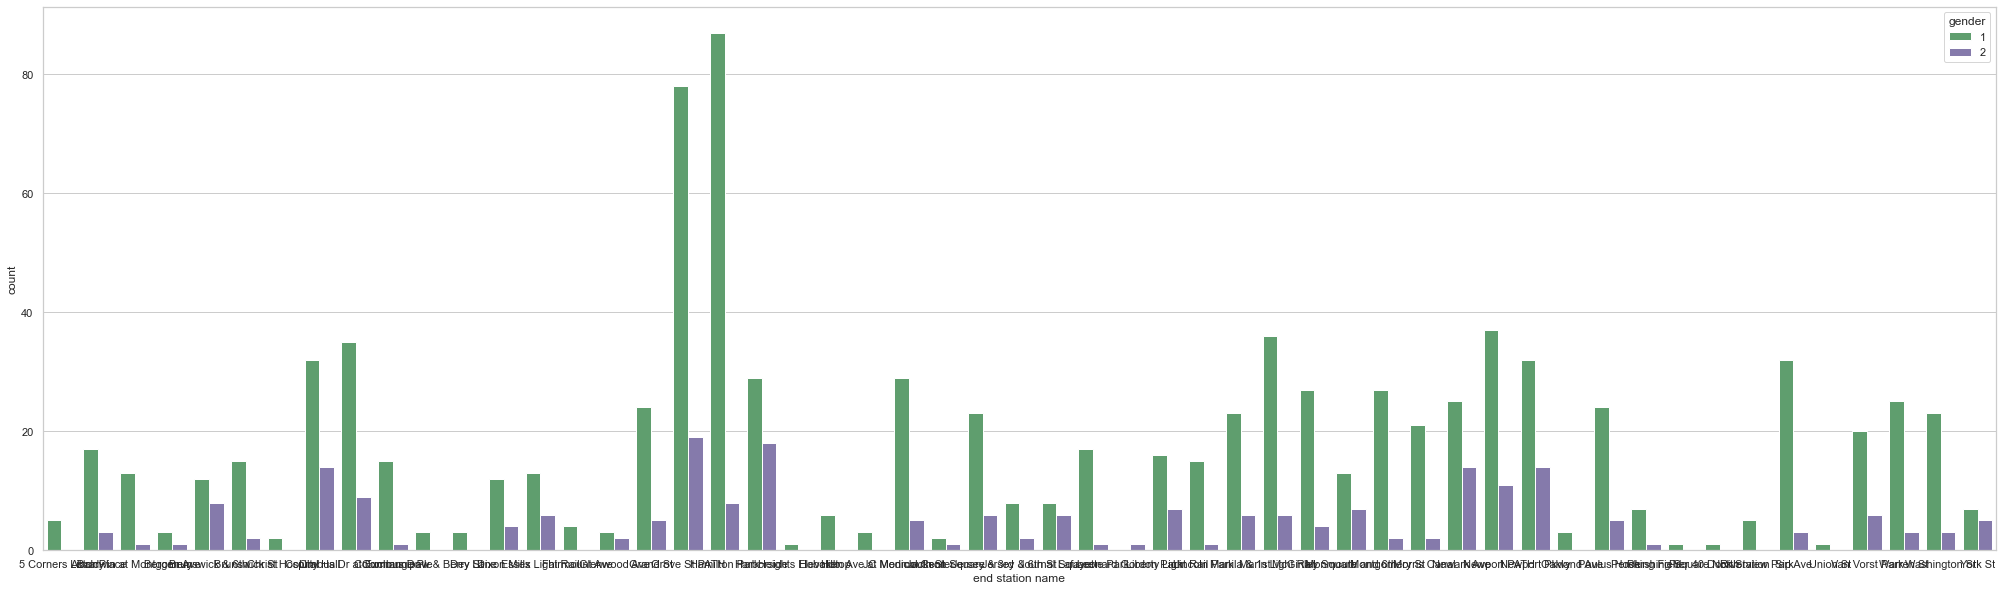

In [53]:
# Plotting
dimensions = (35, 10)
fig, ax = plt.subplots(figsize = dimensions)
usertype_station_plot = sns.countplot(x = 'end station name',
                                      hue = 'gender',
                                      palette = {1: 'g', 2: 'm'},
                                      data = sort_data_end[sort_data_end['gender'] > 0], ax=ax)

Stations in **Grand St.** and **Grove St. Path** have the highest number of *Gender 1* while stations in **Grand St.** and **Hamilton Park** have the highest number of *Gender 2*. It is also important to note that **Lafayette Park**, **Harborside** and **Pershing Field** have the least number of *Gender 1* based from the graph. 

### Bivariate: End Station and User Type

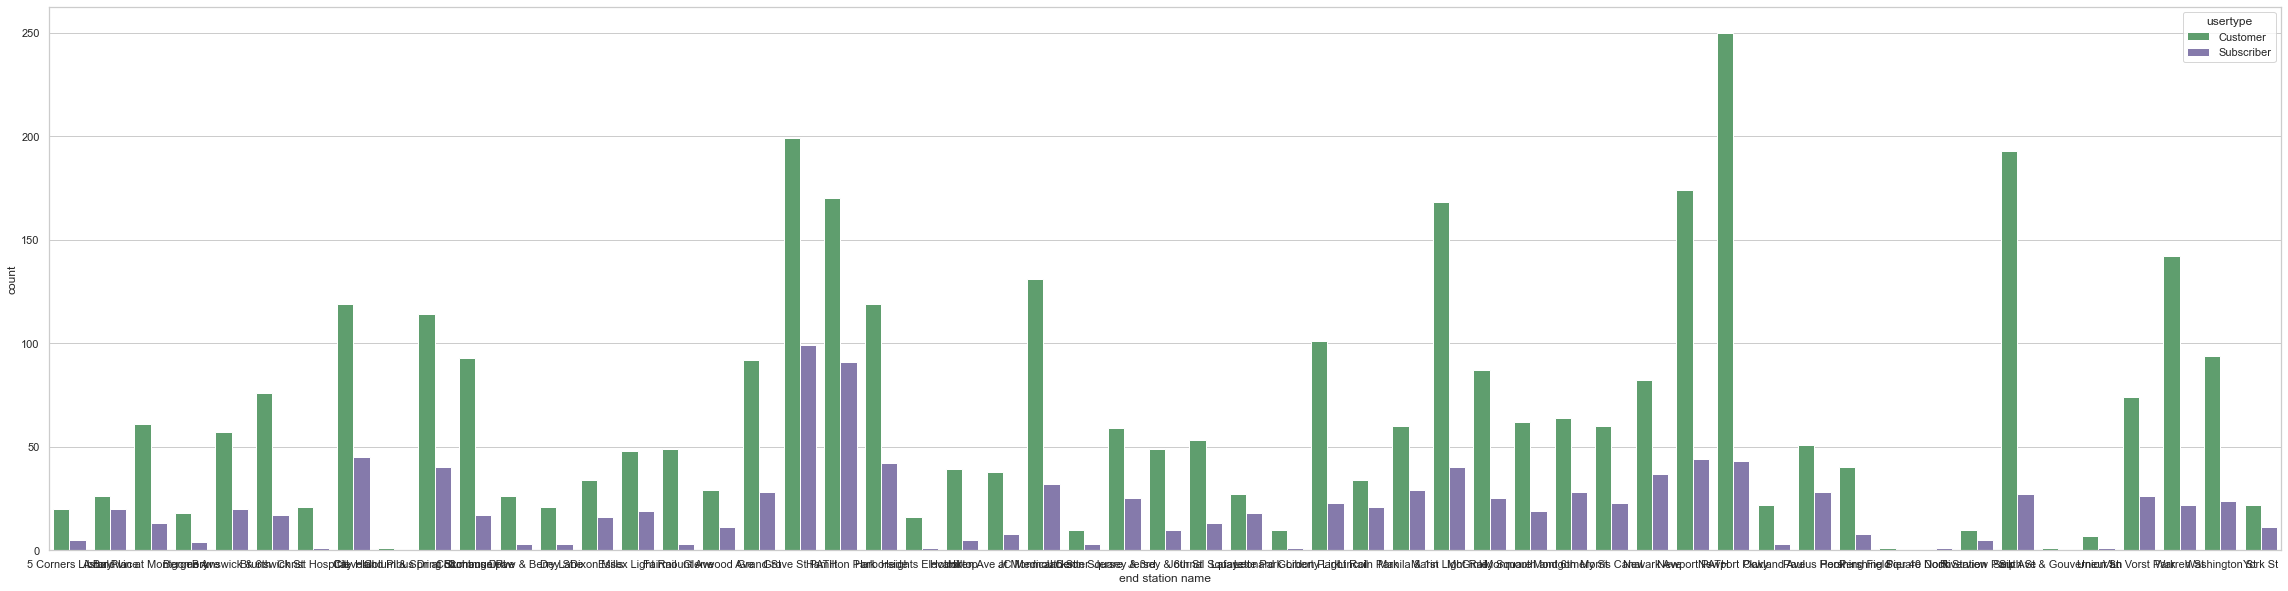

In [54]:
# Plotting
dimensions = (40, 10)
fig, ax = plt.subplots(figsize = dimensions)
sertype_station_plot = sns.countplot(x="end station name", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   data=sort_data_end, ax=ax)

**Grand St.** and **Newport Pkwy** are the top stations with the highest number of customers. **Grove St. Path** and **Hamilton Park** are the top stations with the highest number of subscribers. Stations like **Pershing Square North** and **Pier 40 Dock Station** contain the lowest number of customers.

### Multivariate: Start station, end station & trip duration

In [55]:
## Average trip duration per OD
od_start_end_trips = data.groupby(['start station name', 'end station name'], as_index=False)['duration_min'].mean()
od_start_end_trips = od_start_end_trips.rename(columns={"start station name": "start", "end station name": "end", "duration_min": "duration_min"}, errors="raise")
od_start_end_trips

,start,end,duration_min
0,5 Corners Library,5 Corners Library,23.838889
1,5 Corners Library,Brunswick St,7.133333
2,5 Corners Library,Christ Hospital,9.544444
3,5 Corners Library,City Hall,12.750000
4,5 Corners Library,Columbus Drive,15.216667
...,...,...,...
1149,York St,Newport Pkwy,9.300000
1150,York St,Paulus Hook,4.350000
1151,York St,Van Vorst Park,4.983333
1152,York St,Warren St,7.583333


In [56]:
# Get the trips between the top 10 stations.

od_start_end_trips_topten = od_start_end_trips[od_start_end_trips.start.isin(start_stations["Station name"]) & od_start_end_trips.end.isin(end_stations["Station name"])]
od_start_end_trips_topten

,start,end,duration_min
179,Columbus Dr at Exchange Pl,City Hall,20.350000
185,Columbus Dr at Exchange Pl,Grove St PATH,6.679167
186,Columbus Dr at Exchange Pl,Hamilton Park,10.683333
187,Columbus Dr at Exchange Pl,Harborside,2.250000
192,Columbus Dr at Exchange Pl,Marin Light Rail,7.914815
...,...,...,...
1087,Warren St,JC Medical Center,14.139583
1092,Warren St,Marin Light Rail,11.135417
1098,Warren St,Newport PATH,4.187500
1099,Warren St,Newport Pkwy,9.070000


In [57]:
od_matrix = pd.pivot_table(od_start_end_trips_topten, index='start', columns='end', values='duration_min', aggfunc=np.sum, fill_value=0)
od_matrix

end,City Hall,Grove St PATH,Hamilton Park,Harborside,JC Medical Center,Marin Light Rail,Newport PATH,Newport Pkwy,Sip Ave,Warren St
start,,,,,,,,,,
Columbus Dr at Exchange Pl,20.350000,6.679167,10.683333,2.250000,0.000000,7.914815,10.025641,13.029762,5904.233333,12.763333
Grove St PATH,46.531481,19.594048,6.426667,6.476667,14.680000,5.140278,14.805556,20.400000,40.725000,13.366667
Hamilton Park,7.680556,9.891026,30.080667,9.127778,8.994444,10.108333,8.818519,14.311111,0.000000,11.683333
Harborside,4.416667,14.972917,18.058333,57.608730,17.925000,7.855556,6.410606,9.315152,24.416667,13.216667
JC Medical Center,3.407692,8.966667,28.116667,7.550000,32.002083,3.761111,14.330556,13.783333,0.000000,13.533333
Marin Light Rail,3.227381,3.920370,8.866667,8.818519,19.113636,27.672667,10.005556,14.716667,0.000000,8.682222
Newport PATH,28.103333,12.877778,9.026852,7.052273,21.791667,13.123611,24.025000,20.203448,21.883333,4.907143
Newport Pkwy,16.870833,34.445833,9.858333,11.443939,18.763333,18.930556,20.176389,26.445940,0.000000,13.170667
Sip Ave,19.733333,0.000000,0.000000,32.850000,0.000000,0.000000,28.288889,24.133333,29.678125,27.600000


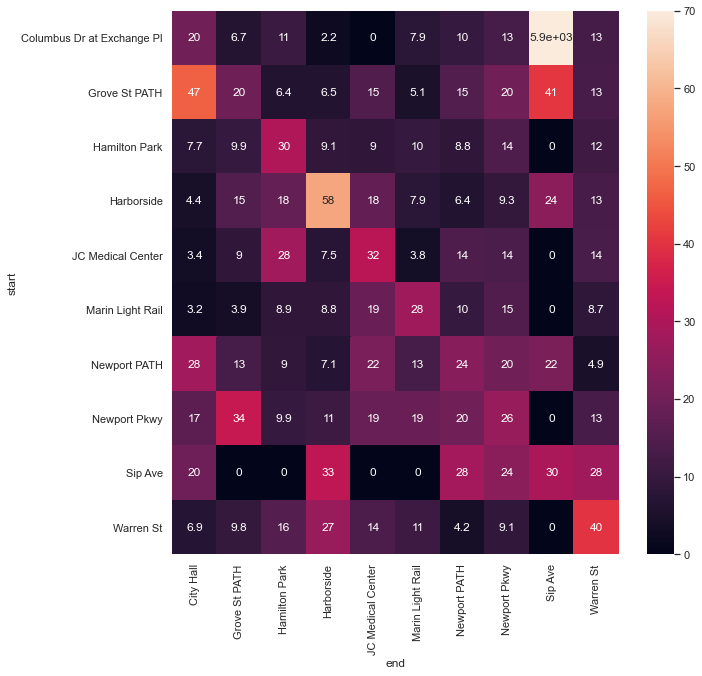

In [58]:
# Generate a heatmap
plt.figure(figsize=(10,10))
od_start_end_trips_heatmap = sns.heatmap(od_matrix, vmin=0, vmax=70, annot=True)

The location on this heatmap were selected based on the top 10 routes that people usually take. Based on the heatmap, we can see that users spent the most time riding bikes going from `Clinton St & Grand Street` TO `E 33 St & 1 Ave`; however, users only spent around 23 minutes going from `E 33 St & 1 Ave` TO `Clinton St &Grand Street`. There were some routes such as `W33 St. & 7 Ave` TO `Grand St. & Elizabeth St.` that people took 21 minutes ;however no one has ever took the opposite route which is `Grand St. & Elizabeth St.` TO `W33 St. & 7 Ave`.

In [59]:
od_start_end_trips["od"] = od_start_end_trips["start"] + " to " + od_start_end_trips["end"]
od_start_end_trips

,start,end,duration_min,od
0,5 Corners Library,5 Corners Library,23.838889,5 Corners Library to 5 Corners Library
1,5 Corners Library,Brunswick St,7.133333,5 Corners Library to Brunswick St
2,5 Corners Library,Christ Hospital,9.544444,5 Corners Library to Christ Hospital
3,5 Corners Library,City Hall,12.750000,5 Corners Library to City Hall
4,5 Corners Library,Columbus Drive,15.216667,5 Corners Library to Columbus Drive
...,...,...,...,...
1149,York St,Newport Pkwy,9.300000,York St to Newport Pkwy
1150,York St,Paulus Hook,4.350000,York St to Paulus Hook
1151,York St,Van Vorst Park,4.983333,York St to Van Vorst Park
1152,York St,Warren St,7.583333,York St to Warren St


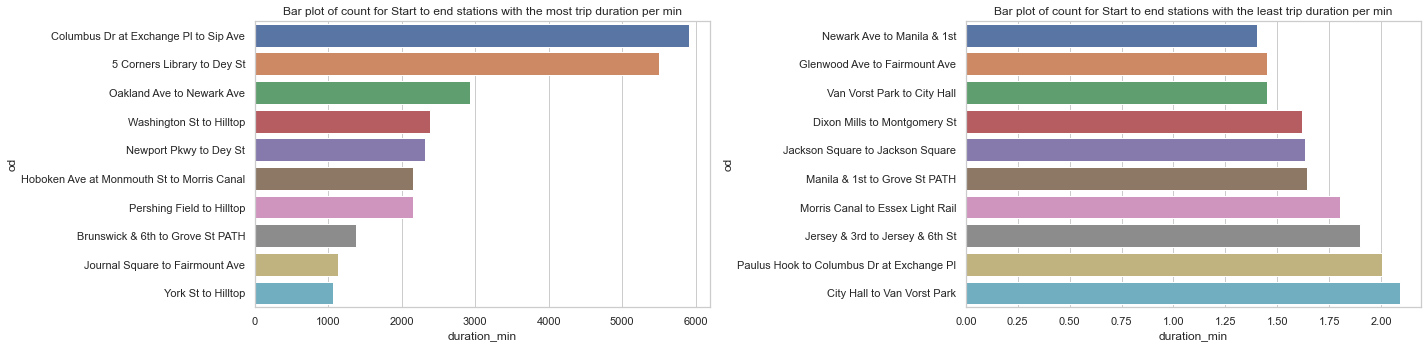

In [60]:
fig, ax = plt.subplots(1,2,figsize=(20, 5))
sns.barplot(y="od", x="duration_min", orient="h", data=od_start_end_trips.nlargest(10, "duration_min"),ax=ax[0])
sns.barplot(y="od", x="duration_min", orient="h", data=od_start_end_trips.nsmallest(10, "duration_min"),ax=ax[1])
ax[0].set_title('Bar plot of count for Start to end stations with the most trip duration per min')
ax[1].set_title('Bar plot of count for Start to end stations with the least trip duration per min')
fig.tight_layout()

On the left we can see the top 10 trip durtions users took the longest on `Norfolk St. & Broome St. to W 10 St. & Washington St.`. On the right we can see the shortest trip durations such as `23 Rd & 29 St. to 24 Ave & 29 St.`, all at around 1.0 minute.

### Multi: Start station, end station & unique users

In [61]:
## Count of bikeid per OD
od_start_end_unique = data.groupby(['start station name', 'end station name'], as_index=False)['bikeid'].nunique()
od_start_end_unique = od_start_end_unique.rename(columns={"start station name": "start", "end station name": "end", "bikeid": "bikeid"}, errors="raise")
od_start_end_unique["od"] = od_start_end_unique["start"] + " to " + od_start_end_unique["end"]
od_start_end_unique

,start,end,bikeid,od
0,5 Corners Library,5 Corners Library,2,5 Corners Library to 5 Corners Library
1,5 Corners Library,Brunswick St,1,5 Corners Library to Brunswick St
2,5 Corners Library,Christ Hospital,3,5 Corners Library to Christ Hospital
3,5 Corners Library,City Hall,1,5 Corners Library to City Hall
4,5 Corners Library,Columbus Drive,1,5 Corners Library to Columbus Drive
...,...,...,...,...
1149,York St,Newport Pkwy,1,York St to Newport Pkwy
1150,York St,Paulus Hook,1,York St to Paulus Hook
1151,York St,Van Vorst Park,1,York St to Van Vorst Park
1152,York St,Warren St,1,York St to Warren St


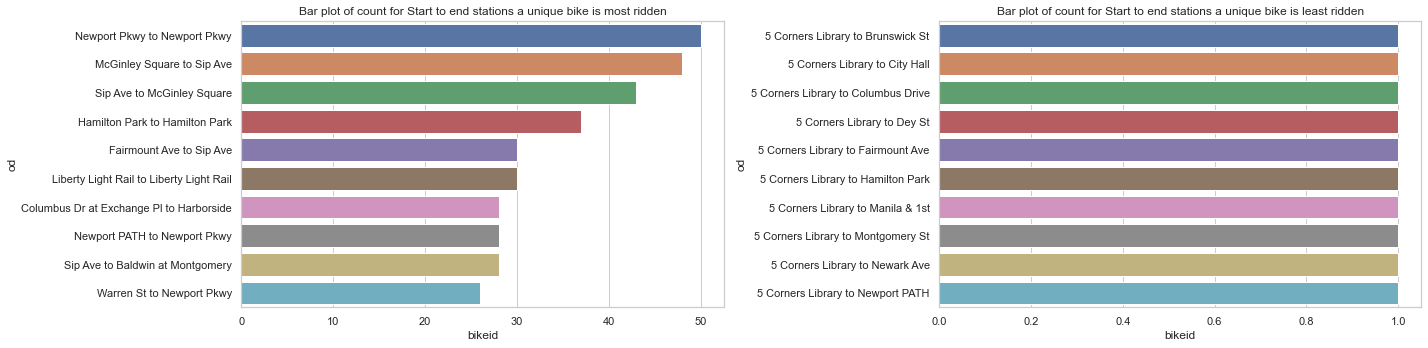

In [62]:
fig, ax = plt.subplots(1,2,figsize=(20, 5))
sns.barplot(y="od", x="bikeid", orient="h", data=od_start_end_unique.nlargest(10, "bikeid"),ax=ax[0])
sns.barplot(y="od", x="bikeid", orient="h", data=od_start_end_unique.nsmallest(10, "bikeid"),ax=ax[1])
ax[0].set_title('Bar plot of count for Start to end stations a unique bike is most ridden')
ax[1].set_title('Bar plot of count for Start to end stations a unique bike is least ridden')
fig.tight_layout()

On the left we can see the routes with the most unique users such as `W21 St & 6 Ave to 9 Ave & W22 St` with over `200` users. On the right, we can see the routes with least unique users, such as `1 Ave & E 110 St to 1 Ave & E 78 St`, all having only `1` user. 

### Multi: Start station, end station & user type

In [63]:
## Count of bikeids per OD with user type
od_start_end_type = data.groupby(['start station name', 'end station name','usertype'], as_index=False)['bikeid'].count()
od_start_end_type = od_start_end_type.rename(columns={"start station name": "start", "end station name": "end", "usertype": "usertype","bikeid":"count"}, errors="raise")
od_start_end_type["od"] = od_start_end_type["start"] + " to " + od_start_end_type["end"]
od_start_end_type

,start,end,usertype,count,od
0,5 Corners Library,5 Corners Library,Customer,3,5 Corners Library to 5 Corners Library
1,5 Corners Library,Brunswick St,Customer,1,5 Corners Library to Brunswick St
2,5 Corners Library,Christ Hospital,Customer,3,5 Corners Library to Christ Hospital
3,5 Corners Library,City Hall,Customer,1,5 Corners Library to City Hall
4,5 Corners Library,Columbus Drive,Customer,1,5 Corners Library to Columbus Drive
...,...,...,...,...,...
1523,York St,Newport Pkwy,Customer,1,York St to Newport Pkwy
1524,York St,Paulus Hook,Subscriber,1,York St to Paulus Hook
1525,York St,Van Vorst Park,Customer,1,York St to Van Vorst Park
1526,York St,Warren St,Subscriber,1,York St to Warren St


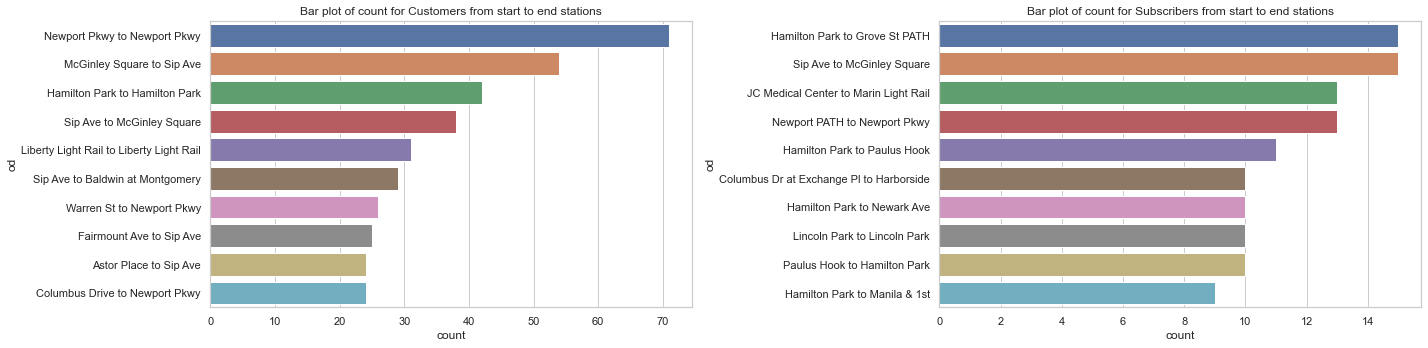

In [64]:
fig, ax = plt.subplots(1,2,figsize=(20, 5))

sns.barplot(y="od", x="count", orient="h", data=od_start_end_type[od_start_end_type["usertype"]=="Customer"].nlargest(10, "count"),ax=ax[0])
sns.barplot(y="od", x="count", orient="h", data=od_start_end_type[od_start_end_type["usertype"]=="Subscriber"].nlargest(10, "count"),ax=ax[1])
ax[0].set_title('Bar plot of count for Customers from start to end stations')
ax[1].set_title('Bar plot of count for Subscribers from start to end stations')
fig.tight_layout()

On the left, we can see the stations with the most number of customers. On the right, we can see the stations with the most number of subscribers. There are some routes that appear on both lists such as `W33 St & 7 Ave to E33 St & 1 Ave`and `E33 St & 1 Ave to W33 St & 7 Ave`.

### Multivariate: Trip Distance, Duration and Gender

Text(0.5, 0.98, 'Multivariate: Trip Distance, Duration and Gender')

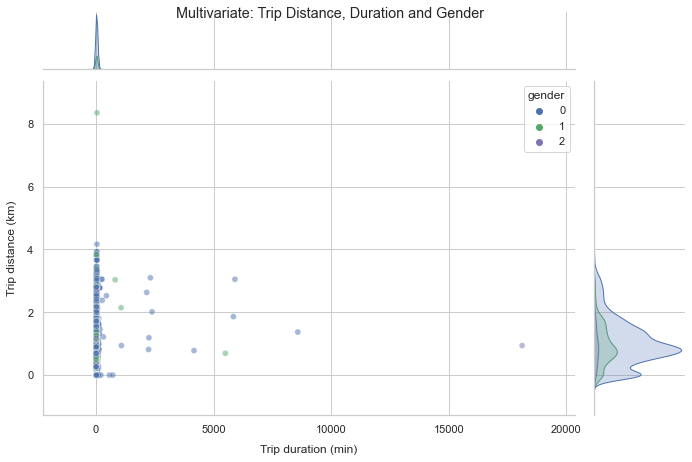

In [65]:
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="gender", 
                                   palette={0: "b", 1: "g", 2: "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)
dur_dist_user_plot.fig.suptitle("Multivariate: Trip Distance, Duration and Gender")

Observations

1. Most people have a trip distance from at least 0km to 4km take up to 200 minutes or 3 hours and 20 minutes.
2. There are some outliers in the graph, such as a trip lasted somewhere from 15,000 minutes to 20,000 minutes for a distance that is between 0km to 2km. (For the sake of the display, the values of x will be limited to 1,500)

### Multi: Average trip distance per unique user, average duration per unique user & user type

In [66]:
dist_dura_user_mean_df = data[filtered_entries & filtered_dist]
dist_dura_user_mean_df = dist_dura_user_mean_df[dist_dura_user_mean_df["distance_km"] != 0]
dist_dura_user_mean_df = dist_dura_user_mean_df[["bikeid", "usertype", "duration_min", "distance_km"]].groupby(by=["bikeid", "usertype"]).mean()
dist_dura_user_mean_df

duration_min  distance_km
bikeid usertype                             
24987  Customer        8.045833     0.582587
       Subscriber      5.066667     0.670987
25265  Customer        7.814583     1.193644
       Subscriber      5.666667     0.660500
25391  Customer       24.254167     1.195592
...                         ...          ...
49081  Subscriber     17.400000     1.662134
49257  Customer        8.279167     1.078532
49467  Customer       13.808333     1.357873
49503  Customer       15.405556     2.090365
       Subscriber      6.644444     1.265533

[806 rows x 2 columns]

Text(0.5, 0.98, 'Average trip distance per unique user, average duration per unique user & user type')

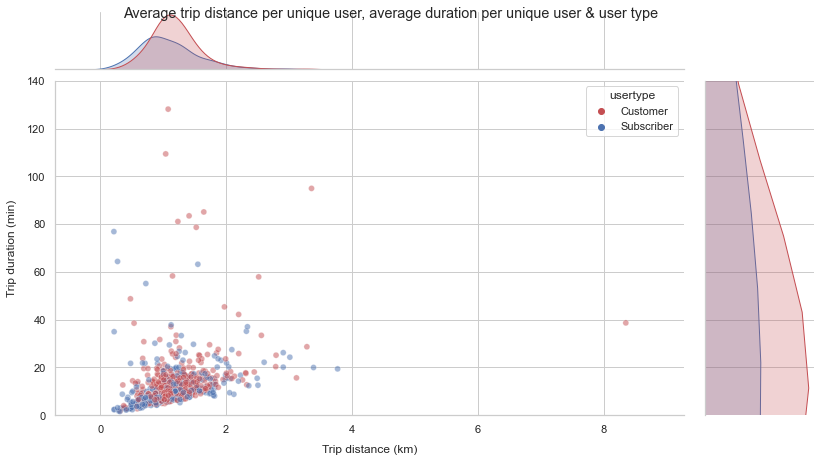

In [67]:
dist_dura_user_mean_plot = sns.jointplot(data=dist_dura_user_mean_df,
                                     x = "distance_km",
                                     y = "duration_min",
                                     hue = "usertype",
                                     palette={'Subscriber': "b", 'Customer': "r"}, 
                                     alpha =0.5,
                                    ylim=(0, 140))
dist_dura_user_mean_plot.set_axis_labels("Trip distance (km)", "Trip duration (min)", labelpad=10)
dist_dura_user_mean_plot.fig.set_size_inches(12.5, 6.5)
dist_dura_user_mean_plot.fig.suptitle("Average trip distance per unique user, average duration per unique user & user type")

##### Observations:
    1. Most people have an average trip distance of 0 to 2 kilometers
    2. Customers generally has higher average trip duration compared to subscribers.

### Multi: Average trip distance per unique user, average duration per unique user, gender & user type

In [68]:
dist_dura_user_mean_df = data[filtered_entries & filtered_dist]
dist_dura_user_mean_df = dist_dura_user_mean_df[["bikeid", "usertype", "duration_min", "distance_km", "gender"]].groupby(by=["bikeid", "usertype"]).mean()
dist_dura_user_mean_df = dist_dura_user_mean_df[dist_dura_user_mean_df["distance_km"] != 0]

Classify diff genders

In [69]:
dist_dura_user_mean_df_0 = dist_dura_user_mean_df[dist_dura_user_mean_df["gender"] == 0] # Gender 0
dist_dura_user_mean_df_1 = dist_dura_user_mean_df[dist_dura_user_mean_df["gender"] == 1] # Gender 1
dist_dura_user_mean_df_2 = dist_dura_user_mean_df[dist_dura_user_mean_df["gender"] == 2] # Gender 2

#### Gender 0 (Unkown)

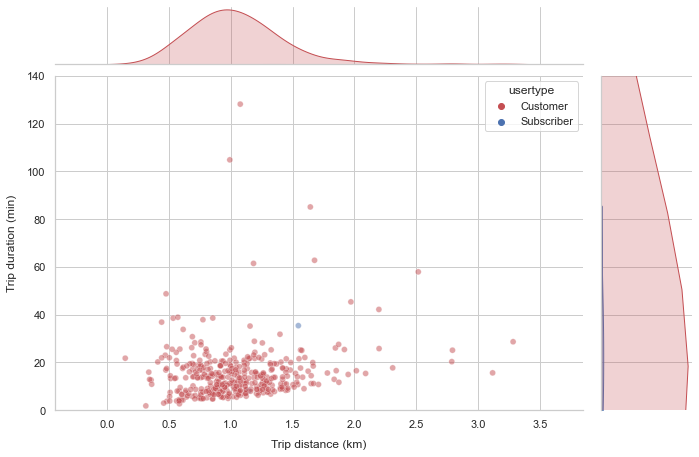

In [70]:
dist_dura_user_mean_plot = sns.jointplot(data=dist_dura_user_mean_df_0,
                                     x = "distance_km",
                                     y = "duration_min",
                                     hue = "usertype",
                                     palette={'Subscriber': "b", 'Customer': "r"}, 
                                     alpha =0.5,
                                    ylim=(0, 140))
dist_dura_user_mean_plot.set_axis_labels("Trip distance (km)", "Trip duration (min)", labelpad=10)
dist_dura_user_mean_plot.fig.set_size_inches(10.5, 6.5)

#### Gender 1 (Male)

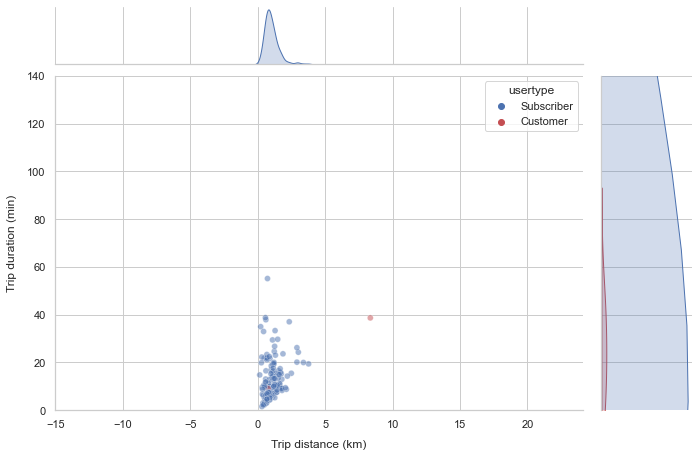

In [71]:
dist_dura_user_mean_plot = sns.jointplot(data=dist_dura_user_mean_df_1,
                                     x = "distance_km",
                                     y = "duration_min",
                                     hue = "usertype",
                                     palette={'Subscriber': "b", 'Customer': "r"}, 
                                     alpha =0.5,
                                    ylim=(0, 140))
dist_dura_user_mean_plot.set_axis_labels("Trip distance (km)", "Trip duration (min)", labelpad=10)
dist_dura_user_mean_plot.fig.set_size_inches(10.5, 6.5)

#### Gender 2 (Female)

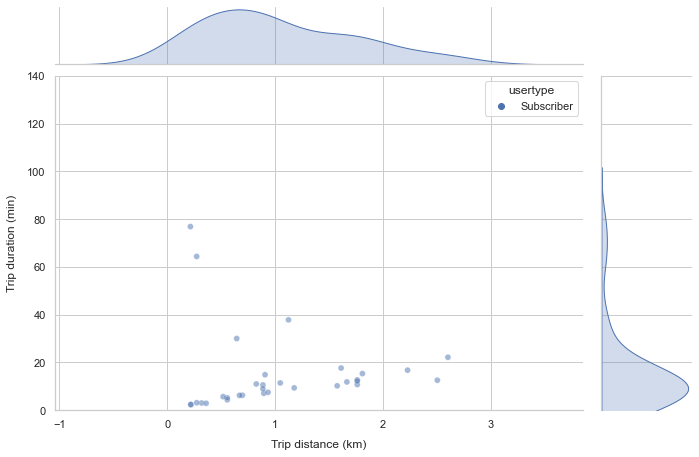

In [72]:
dist_dura_user_mean_plot = sns.jointplot(data=dist_dura_user_mean_df_2,
                                     x = "distance_km",
                                     y = "duration_min",
                                     hue = "usertype",
                                     palette={'Subscriber': "b", 'Customer': "r"}, 
                                     alpha =0.5,
                                    ylim=(0, 140))
dist_dura_user_mean_plot.set_axis_labels("Trip distance (km)", "Trip duration (min)", labelpad=10)
dist_dura_user_mean_plot.fig.set_size_inches(10.5, 6.5)

##### Observation:
    1. Majority of unkown users are customers.
    2. Males have relatively close observations in both trip distance and duration (majority falls under 20 mins duration and 0.5 to 1.5km trip distance) compared to females.
    